# Loading TensorFlow tuned model checkpoint into PyTorch model on the classification task



## PyTorch code

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns; sns.set()
import numpy as np
import torch
from modeling import BertConfig, BertForSequenceClassification
import tokenization
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# from run_squad import *

In [2]:
init_checkpoint_pt = "./pretrained_models/yelp_tuned_from_tf.pt"
bert_config_file = "./bert_configs/bert_config.json"
bert_config = BertConfig.from_json_file(bert_config_file)

In [3]:
device = torch.device("cuda")
model = BertForSequenceClassification(bert_config, 2)
model.load_state_dict(torch.load(init_checkpoint_pt, map_location='cpu'))
model.eval()
model.to(device)
criterion_ce = torch.nn.CrossEntropyLoss().to(device)
print("Loaded model.")

Loaded model.


In [4]:
tokenizer = tokenization.FullTokenizer(
        vocab_file='./bert_configs/vocab.txt', do_lower_case=False)
id_to_word = dict([(i,w) for (w,i) in tokenizer.vocab.items()])

In [5]:
# id_to_word
# 0: '[PAD]'
# 1: 'xxx'
# ...
tokenizer.tokenize("I love gression place.")

['I', 'love', 'g', '##ression', 'place', '.']

In [6]:
# Model needs input_ids, token_type_ids, attention_mask,
def send_sent_to_model(model, sent):
    input_ids = []
    input_ids.append( tokenizer.convert_tokens_to_ids(["[CLS]"] + sent + ["[SEP]"]) )
    input_mask = [[1]*len(ii) for ii in input_ids]
    # print(input_mask)
    input_ids = torch.tensor(input_ids, dtype=torch.long)
    input_mask = torch.tensor(input_mask, dtype=torch.long)
    token_type_ids = torch.tensor(torch.zeros(input_mask.size()).long())

    # eval_data = TensorDataset(input_ids, input_mask, token_type_ids)
    # eval_sampler = SequentialSampler(eval_data)
    # eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)

    # batch = iter(eval_dataloader).next()
    # input_ids, input_mask, token_type_ids = batch
    # print([t.shape for t in batch])

    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    token_type_ids = token_type_ids.to(device)

    logits = model(input_ids, input_mask, token_type_ids)

    #print(logits)
    return logits


In [118]:
# Papernot method
sent = "I have zero complaints about the service or the prices."
sent = tokenizer.tokenize(sent)
original_label = 1
target_label = 1 if original_label == 0 else 0
# print(sent)
pre_attention_data = None
org_sent_len = len(sent)
new_sent = sent
for target_word_pos in range(org_sent_len):
    print(new_sent)
    model.zero_grad()
    model_out = send_sent_to_model(model, new_sent)
    # print(model_out)
    if pre_attention_data is None:
        pre_attention_data = model.bert.encoder.layer[0].attention.self.attention_probs.detach().cpu().numpy()
        pre_attention_data = np.squeeze(pre_attention_data, 0)
    if torch.max(model_out, -1)[1] == target_label:
        print("Job done.")
        break
    y_target = torch.tensor([target_label]).to(device)

    loss = criterion_ce(model_out, y_target)
    loss.backward(retain_graph=True) # obtain gradients on x

    grad_of_word_embd = model.bert.embeddings.word_embeddings.weight.grad.detach()
    word_embd = model.bert.embeddings.word_embeddings.weight.detach()
    # sorted_grad_vals, sorted_idxs = torch.sort(torch.norm(grad_of_word_embd, dim=1), descending=True)
    min_dist = 9999.0
    best_new_word_id = 106
    target_word = tokenizer.vocab[new_sent[target_word_pos]]
    for i in range(106, len(id_to_word)): # 106 = first word that is not special marker in vocab
        if i == target_word: continue

        dd = torch.sum(torch.abs(
               torch.sign(word_embd[target_word] - word_embd[i]) -
               torch.sign(grad_of_word_embd[target_word])))
        if dd < min_dist:
            min_dist = dd
            best_new_word_id = i
    # print(id_to_word[best_new_word_id])
    # print(min_dist)
    new_sent = new_sent[:target_word_pos] + [id_to_word[best_new_word_id]] + new_sent[target_word_pos+1:]

print(new_sent)

['I', 'have', 'zero', 'complaints', 'about', 'the', 'service', 'or', 'the', 'prices', '.']
['Roche', 'have', 'zero', 'complaints', 'about', 'the', 'service', 'or', 'the', 'prices', '.']
['Roche', 'will', 'zero', 'complaints', 'about', 'the', 'service', 'or', 'the', 'prices', '.']
['Roche', 'will', 'logistics', 'complaints', 'about', 'the', 'service', 'or', 'the', 'prices', '.']
Job done.
['Roche', 'will', 'logistics', 'complaints', 'about', 'the', 'service', 'or', 'the', 'prices', '.']


In [128]:
## Remove max attention method
filler = '[🐱]'
sent = "I have zero complaints about the service or the prices."
original_label = 1
# sent = "The food is good. Unfortunately the service is very hit or miss."
# original_label = 0
target_label = 1 if original_label == 0 else 0

# Do attack
sent = tokenizer.tokenize(sent)
model_out = send_sent_to_model(model, sent)
pre_attention_data = model.bert.encoder.layer[0].attention.self.attention_probs.detach().cpu().numpy()
pre_attention_data = np.squeeze(pre_attention_data, 0)
attention_max_pos = list(np.argsort(np.mean(pre_attention_data, axis=0)[:,0])[::-1])
# print(attention_max_pos)
new_sent = sent
print(new_sent)
while True:
    target_word_pos = attention_max_pos.pop(0)-1
    if target_word_pos == len(new_sent):
        # Got [SEP] label, skip
        continue
    if target_word_pos == -1:
        # Got [CLS] label, skip
        continue
    new_sent = new_sent[:target_word_pos] + [filler] + new_sent[target_word_pos+1:]
    print(new_sent)
    model_out = send_sent_to_model(model, new_sent)
    pred_logit, predict_label = torch.max(model_out, -1)
    predict_label = int(predict_label)
    if predict_label == target_label:
        print("Job done. Label from {} to {}.".format(original_label, predict_label))
        break
    else:
        print("Predict ", predict_label)
    
    if len(attention_max_pos) < 1: 
        print("No word to change.")
        break

# print(new_sent)

['I', 'have', 'zero', 'complaints', 'about', 'the', 'service', 'or', 'the', 'prices', '.']
['I', 'have', 'zero', 'complaints', 'about', 'the', 'service', 'or', 'the', '[🐱]', '.']
Predict  1
['I', 'have', '[🐱]', 'complaints', 'about', 'the', 'service', 'or', 'the', '[🐱]', '.']
Predict  1
['I', 'have', '[🐱]', 'complaints', '[🐱]', 'the', 'service', 'or', 'the', '[🐱]', '.']
Job done. Label from 1 to 0.


In [126]:
tokenizer.vocab.get('fff', tokenizer.vocab['[UNK]'])

100

In [99]:
post_attention_data = model.bert.encoder.layer[0].attention.self.attention_probs.detach().cpu().numpy()
post_attention_data = np.squeeze(post_attention_data, 0)

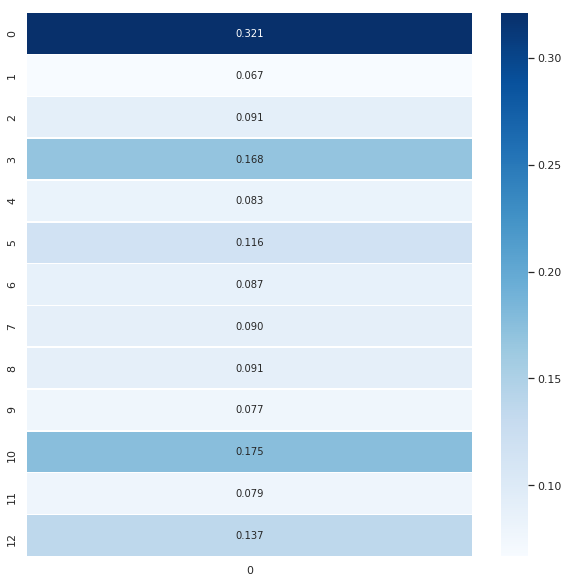

In [100]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(np.mean(pre_attention_data, axis=0)[:,0:1], linewidths=.5, cmap="Blues", annot=True, fmt=".3f")

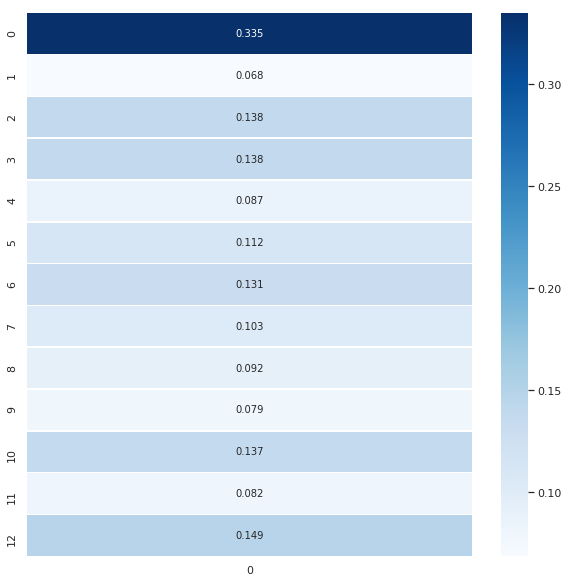

In [101]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(np.mean(post_attention_data, axis=0)[:,0:1], linewidths=.5, cmap="Blues", annot=True, fmt=".3f")

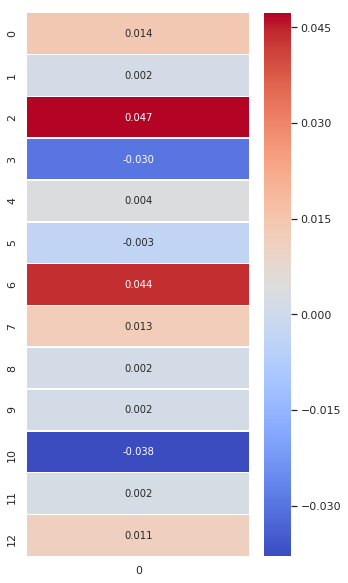

In [102]:
fig = plt.figure(figsize=(5, 10))
sns.heatmap(np.mean(post_attention_data-pre_attention_data, axis=0)[:,0:1], linewidths=.5, cmap="coolwarm", annot=True, fmt=".3f")

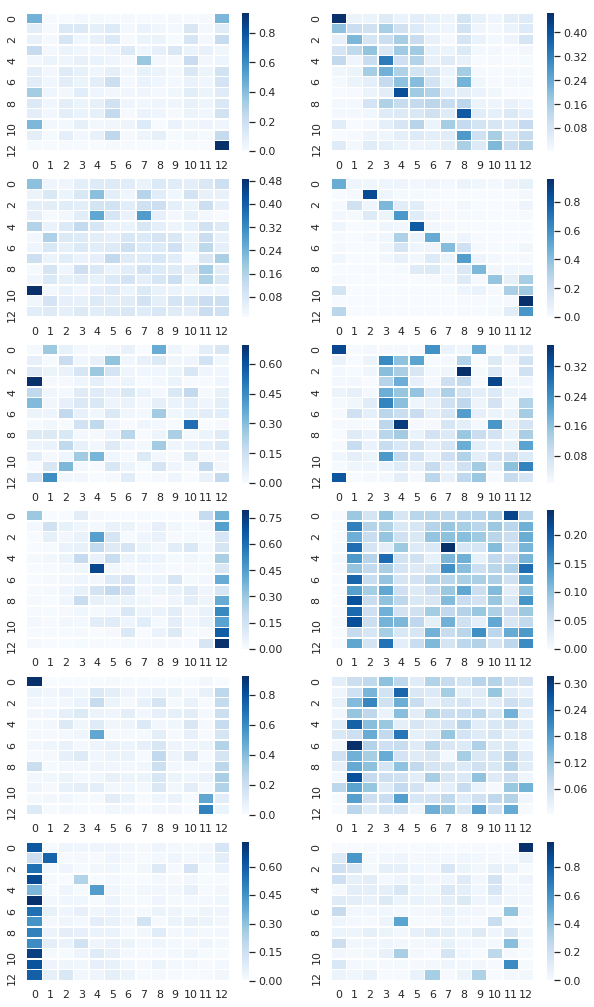

In [103]:
fig = plt.figure(figsize=(10, 30))
for i in range(1, 13):
    plt.subplot(10, 2, i)
    ax = sns.heatmap(pre_attention_data[i-1],linewidths=.5,cmap="Blues")

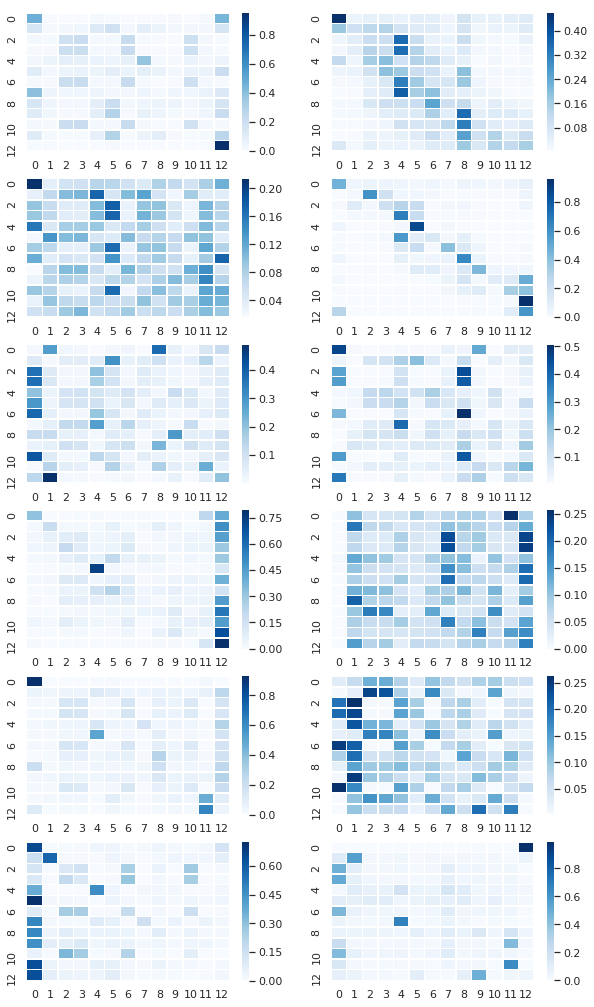

In [104]:
fig = plt.figure(figsize=(10, 30))
for i in range(1, 13):
    plt.subplot(10, 2, i)
    ax = sns.heatmap(post_attention_data[i-1],linewidths=.5,cmap="Blues")

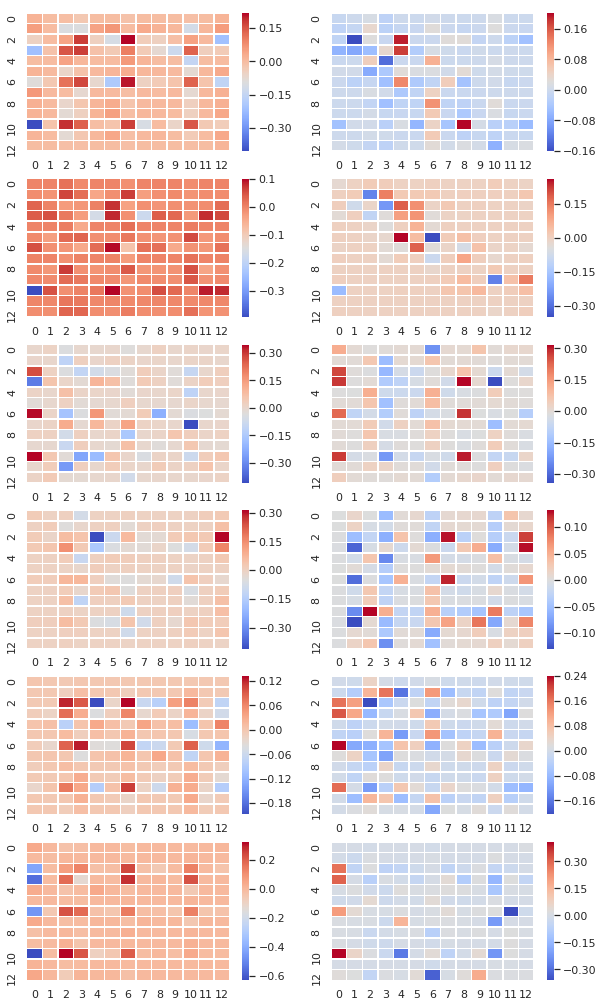

In [105]:
fig = plt.figure(figsize=(10, 30))
for i in range(1, 13):
    plt.subplot(10, 2, i)
    ax = sns.heatmap(post_attention_data[i-1] - pre_attention_data[i-1],linewidths=.5,cmap="coolwarm")


In [106]:
torch.cuda.empty_cache()